# Evaluate digital twin

In this notebook, you will evaluate your newly trained digital twin by computing:

$CC_{abs}$

$CC_{max}$

$CC_{norm}$

You will need to have prepared evaluation data as described in the data preparation tutorial.

Ensure that the paths to your state_dict and evaluation data are correct in the training config file.

By default, this config file is found at: 

```
/workspace/fnn/data/train_digital_twin/config.yaml
```

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from fnn.microns import load_network_from_params
from fnn.data import load_evaluation_data
from fnn import evaluate
import yaml
from tqdm import tqdm

## load config

In [2]:
path_to_config = Path('/workspace/fnn/data/train_digital_twin/config.yaml')
with open(path_to_config, 'r') as f:
    config = yaml.safe_load(f)

## specify paths

In [3]:
results_dir = Path(config['save-state']['directory'])
path_to_params = results_dir / config['save-state']['state_dict']
evaluation_data_dir = Path(config['data-source']['evaluation']['directory'])

## load model

In [4]:
model = load_network_from_params(path_to_params)

## load evaluation data

In [5]:
evaluation_data = load_evaluation_data(evaluation_data_dir)

Subdirectories: 100%|██████████| 4/4 [00:48<00:00, 12.13s/it]


## $CC_{max}$

In [ ]:
units_fmt = evaluate.format_responses(evaluation_data['units'], burnin_frames=config['objective']['burnin_frames'])

In [7]:
cc_max = evaluate.compute_cc_max(units_fmt)

/workspace/fnn/fnn/evaluate/__init__.py:100: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(SP / y_m_v)


In [8]:
fig, ax = plt.subplots()
_ = ax.hist(cc_max, bins=100)
_ = ax.set_xlabel('$CC_{max}$')
_ = ax.set_ylabel('counts')

## $CC_{abs}$

## compute model predictions

In [9]:
s = evaluation_data['stimuli']
p = evaluation_data['perspectives']
m = evaluation_data['modulations']

units_pred = []
for i in tqdm(range(len(s)), desc="Stimuli"):
    repeats_pred = []
    for j in range(len(s[i])):
        repeats_pred.append(
            model.predict(
                stimuli=s[i][j],
                perspectives=p[i][j],
                modulations=m[i][j]
            )
        )
    units_pred.append(repeats_pred)

Stimuli: 100%|██████████| 6/6 [07:58<00:00, 79.79s/it]


In [10]:
units_pred_fmt = evaluate.format_responses(units_pred, burnin_frames=10)

In [11]:
cc_abs = evaluate.compute_cc_abs(units_pred_fmt, units_fmt)

In [12]:
fig, ax = plt.subplots()
_ = ax.hist(cc_abs, bins=100)
_ = ax.set_xlabel('$CC_{abs}$')
_ = ax.set_ylabel('counts')

## $CC_{norm}$

In [13]:
cc_norm = cc_abs / cc_max

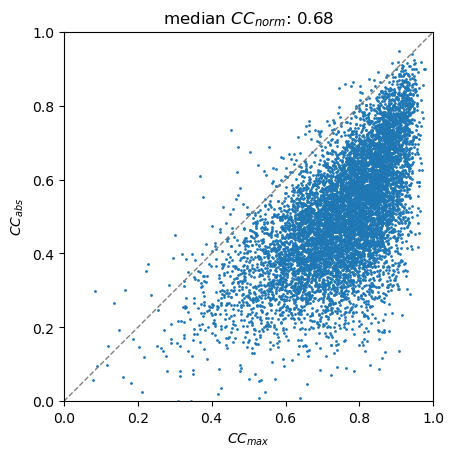

In [14]:
fig, ax = plt.subplots()
ax.scatter(cc_max, cc_abs, s=1)
ax.plot([0, 1], [0, 1], ls='--', lw=1, c='gray')
ax.set_title(f'median $CC_{{norm}}$: {np.nanmedian(cc_norm):.2f}')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('$CC_{max}$')
ax.set_ylabel('$CC_{abs}$')
ax.set_aspect('equal')